In [1]:
import string, re, json, pickle, warnings, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from data_preparation import take_a_shower, clean_content_aravec
from utils import *

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
data = pd.read_csv('./data/offensive_dataset.csv', encoding="utf-16")
data.head()

,Comment,is_off
0,شوف حد ين*** أنت و إيران.,1
1,شوف تيفي قوداتها مع الجن غي بلاتي يجي من مكة,0
2,عجب يتفاوظون على شعوب عربية وعليهم وهىلا تعلم,0
3,ههههههه هاد شوف تيفي اللي حطت عليه مشا فيها,0
4,الرزق يأتي من حيث لا تدري 🙌🏻❤️,0


<AxesSubplot:xlabel='is_off', ylabel='count'>

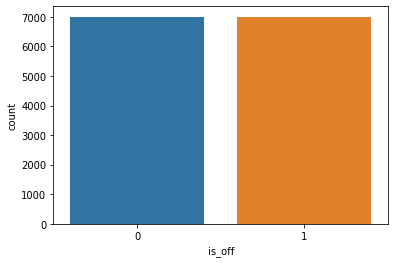

In [4]:
sns.countplot(x='is_off', data=data)

In [5]:
data.Comment = data.Comment.apply(take_a_shower)
data.shape

(14000, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  14000 non-null  object
 1   is_off   14000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 218.9+ KB


In [7]:
data.head()

,Comment,is_off
0,شوف حد ايران,1
1,شوف تيفي قوداتها الجن غي بلاتي يجي مكه,0
2,عجب يتفاوظون شعوب عربيه وعليهم وهيلا تعلم,0
3,هه هاد شوف تيفي اللي حطت مشا,0
4,الرزق ياتي تدري 🙌🏻❤️,0


# AraVec Embedding

In [8]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelEncoder
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import Callback
from keras.utils import np_utils
from keras.regularizers import l1,l2
import gensim

In [9]:
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100 #176 # based on our inputs; TODO: remove outliers? dynamically calculate!
EMBEDDING_DIM = 100 # w2v, fastText; GloVe=50

In [10]:
# path = './bin/aravec/tweets_sg_100'
path = './bin/aravec/full_grams_sg_300_twitter.mdl'
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(path)

In [11]:
print(MAX_FEATURES)
print(EMBED_SIZE)

1476715
300


In [12]:
# load data
x = data.Comment.values
y = data.is_off.values
MAX_TEXT_LENGTH = get_max_length(x)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('Dataset splited.')
CLASSES_LIST = np.unique(y)
print('Label categories: ' + str(CLASSES_LIST))
print("Max Length: " + str(MAX_TEXT_LENGTH))

Dataset splited.
Label categories: [0 1]
Max Length: 461


In [13]:
# Sequence length
print("Original sequence length : "+str(MAX_TEXT_LENGTH))

# CHANGE MAX LENGTH (timesteps)
MAX_TEXT_LENGTH = 200
MAX_FEATURES = 20000

Original sequence length : 461


In [14]:
x_train, x_test, y_train, y_test, word_index = class_str_2_ind(X_train, X_test, 
                                                                            Y_train, Y_test,
                                                                            CLASSES_LIST, MAX_FEATURES,
                                                                            MAX_TEXT_LENGTH)
print('Found %d unique words.' % len(word_index))

Converting data to trainable form...
Number of training examples: 11200
Number of testing examples: 2800
Found 44530 unique words.


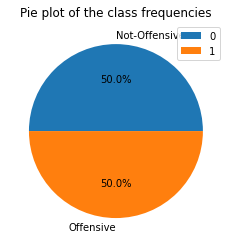

In [15]:
LABELS = ('Not-Offensive', 'Offensive')
tmp = np.concatenate((y_train, y_test))
unique, counts = np.unique(tmp, return_counts=True)
del tmp
plt.figure("Target Pie")
plt.title("Pie plot of the class frequencies")
plt.pie(counts, labels=LABELS, autopct='%1.1f%%')
plt.legend(unique)
# plt.savefig("./img/stats_classes.png")
plt.show();

In [16]:
print("Parameters Values:")
print("word_index: ")
print(len(word_index))
print("WORD_MODEL: ")
print(WORD_MODEL)
print("EMBED_SIZE: ")
print(EMBED_SIZE)
print("MAX_TEXT_LENGTH: ")
print(MAX_TEXT_LENGTH)
print("MAX_FEATURES:")
print(MAX_FEATURES)

embedding_matrix, words_not_found = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)

Parameters Values:
word_index: 
44530
WORD_MODEL: 
EMBED_SIZE: 
300
MAX_TEXT_LENGTH: 
200
MAX_FEATURES:
20000
Building embedding matrix...
Embedding matrix built.


In [17]:
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 8829


In [18]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['درابكم' 'خامنیی' 'وبورقيبه' 'الضو🤲' 'غلشي' 'مءلفه' 'طواءف' 'كنكول'
 'الاصنين' 'كنحلمو']


## LSTM

In [36]:
def get_lstm_model(embedding_weights, word_index, vocab_dim, max_length, print_summary=True):
    print("Build LSTM Model ...")

    """
    MAX_FEATURES: 331679
    MAX_TEXT_LENGTH: 100
    =========================
    Training Accuracy: 0.8969
    Training Loss: 0.2534
    =========================
    Testing Accuracy:  0.7900
    Testing Loss:  0.5070
    
    MAX_FEATURES: 20000
    MAX_TEXT_LENGTH: 200
    =========================
    Training Accuracy: 0.9485
    Training Loss: 0.1688
    =========================
    Testing Accuracy:  0.8186
    Testing Loss:  0.6079
    
    MAX_FEATURES: 10000
    MAX_TEXT_LENGTH: 200
    =========================
    Training Accuracy: 0.9145
    Training Loss: 0.2280
    =========================
    Testing Accuracy:  0.8071
    Testing Loss:  0.4580
    """    
    model = Sequential()
    model.add(Input(shape=(max_length,)))
    model.add(Embedding(input_dim=len(word_index)+1, 
                        output_dim=vocab_dim, 
                        trainable=False,
                        weights=[embedding_weights]))
    model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model

In [39]:
model = get_lstm_model(embedding_matrix, 
                       word_index, 
                       EMBED_SIZE, 
                       MAX_TEXT_LENGTH, 
                       print_summary=True)

Build LSTM Model ...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          13359300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 32)           42624     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (Non

In [40]:
history, model = train_fit_predict(model,
                               x_train,
                               x_test,
                               y_train, y_test,
                               batch_size=64, epochs=25)

Epoch 1/25
140/140 [==============================] - 29s 206ms/step - loss: 0.6664 - accuracy: 0.5939 - val_loss: 0.5850 - val_accuracy: 0.6848
Epoch 2/25
140/140 [==============================] - 28s 202ms/step - loss: 0.5620 - accuracy: 0.7266 - val_loss: 0.5202 - val_accuracy: 0.7406
Epoch 3/25
140/140 [==============================] - 28s 203ms/step - loss: 0.5221 - accuracy: 0.7477 - val_loss: 0.5031 - val_accuracy: 0.7598
Epoch 4/25
140/140 [==============================] - 29s 208ms/step - loss: 0.5042 - accuracy: 0.7627 - val_loss: 0.4787 - val_accuracy: 0.7728
Epoch 5/25
140/140 [==============================] - 29s 210ms/step - loss: 0.4752 - accuracy: 0.7765 - val_loss: 0.4740 - val_accuracy: 0.7777
Epoch 6/25
140/140 [==============================] - 30s 214ms/step - loss: 0.4620 - accuracy: 0.7883 - val_loss: 0.4586 - val_accuracy: 0.7812
Epoch 7/25
140/140 [==============================] - 28s 204ms/step - loss: 0.4465 - accuracy: 0.7916 - val_loss: 0.4438 - val_ac

In [41]:
loss, accuracy = model.evaluate(x_train, y_train)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss_val, accuracy_val = model.evaluate(x_test, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))
print("Testing Loss:  {:.4f}".format(loss_val))

350/350 [==============================] - 15s 43ms/step - loss: 0.2678 - accuracy: 0.8838
Training Accuracy: 0.8838
Training Loss: 0.2678
88/88 [==============================] - 4s 44ms/step - loss: 0.4556 - accuracy: 0.8096
Testing Accuracy:  0.8096
Testing Loss:  0.4556


In [42]:
y_pred = model.predict(x_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_pred = (y_pred > 0.5)

print(classification_report(y_test, y_pred))

88/88 [==============================] - 4s 44ms/step
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1384
           1       0.86      0.75      0.80      1416

    accuracy                           0.81      2800
   macro avg       0.82      0.81      0.81      2800
weighted avg       0.82      0.81      0.81      2800



In [43]:
n = np.argmin(history.history['val_loss'])

print("Optimal epoch : {}".format(n))
print("Accuracy on train : {} %".format(np.round(history.history['accuracy'][n]*100, 2)))
print("Accuracy on test : {} %".format(np.round(history.history['val_accuracy'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on test : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Optimal epoch : 20
Accuracy on train : 84.69 %
Accuracy on test : 80.98 %
Loss on train : 34.17
Loss on test : 40.38


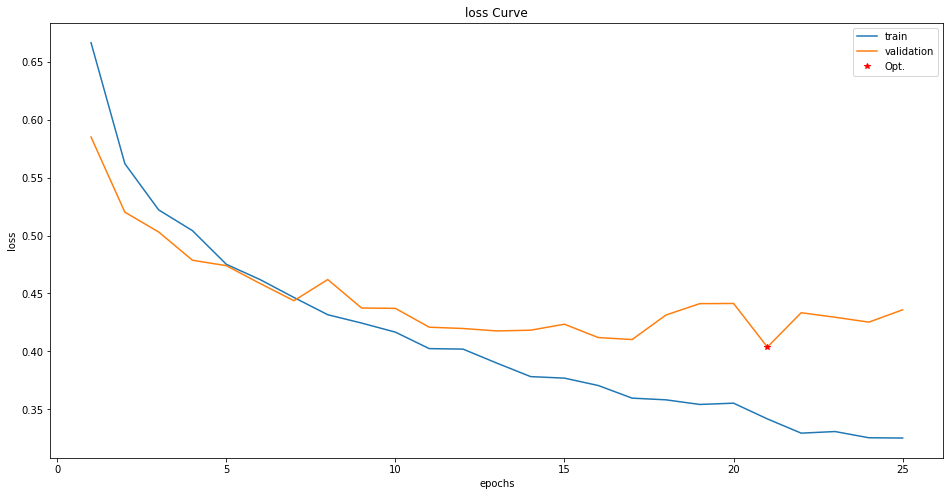

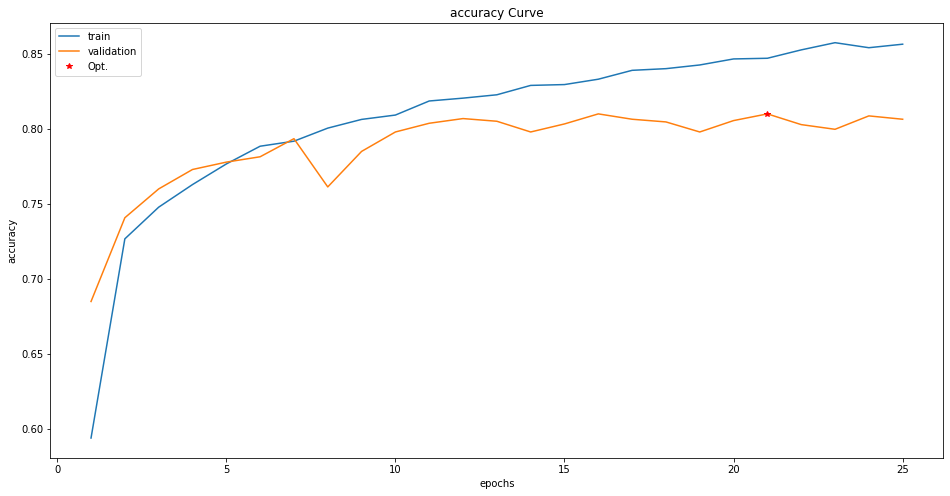

In [44]:
#train loss vs validation loss
show_train_history(history,'loss','val_loss', n)

show_train_history(history,'accuracy','val_accuracy', n)

In [45]:
pred_test = model.predict(x_test, verbose=True)
df_blind = pd.DataFrame({'REAL': y_test, 
                         'PRED': pred_test.reshape(pred_test.shape[0],), 
                         'TEXT': X_test})
df_blind = df_blind.reset_index()[['REAL', 'PRED', 'TEXT']]
df_blind.PRED = df_blind.PRED.round()
error_records = df_blind[df_blind.REAL != df_blind.PRED]

88/88 [==============================] - 4s 43ms/step


In [46]:
print("Number of misclassified reviews: {} out of {}".format(error_records.shape[0], df_blind.shape[0]))
print("Blind Test Accuracy:  {:.4f}".format(accuracy_score(df_blind.REAL, df_blind.PRED)))

Number of misclassified reviews: 533 out of 2800
Blind Test Accuracy:  0.8096


In [47]:
print(len(df_blind[df_blind.REAL != df_blind.PRED]))

533


In [48]:
df_blind[df_blind.PRED == 0]

,REAL,PRED,TEXT
3,0,0.0,حياه انسان لحظه لاتعود الحياه بعدها قبلها
5,0,0.0,سيري الله يمسخك صبات سحات بغيتي يديها فسوق راس...
6,1,0.0,جبهه النصره تعرف القاعده مربط الجمل
7,0,0.0,اتحدي النظام يفعل اللحظه <NUM> الامام
8,0,0.0,<NUM> <NUM>
...,...,...,...
2791,1,0.0,وبعديين 😔 اثق بشخص انو قلبو عالقضيه وشريف بنفض...
2792,1,0.0,وقتل <NUM> سعوديا الحدود برصاص القبايل <NUM> م...
2793,1,0.0,كيانك نتيجه استفتاء لتبارك للاسبانيا فتحها الع...
2796,1,0.0,كيتلوا بحال لفعه الله يعطك دقه جدي طاح ناد


In [315]:
save_model('aravec', 'lstm', round(accuracy_val, 4))

Model Saved Successfully in ./models/aravec/


## BiLSTM

In [19]:
def get_bilstm_model(embedding_weights, word_index, vocab_dim, max_length, print_summary=True):
    print("Build BiLSTM Model ...")
    
    model = Sequential()
    model.add(Input(shape=(max_length,)))
    model.add(Embedding(input_dim=len(word_index)+1, 
                        output_dim=vocab_dim, 
                        trainable=False,
                        weights=[embedding_weights]))
    model.add(Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model

In [20]:
bi_model = get_bilstm_model(embedding_matrix, 
                       word_index, 
                       EMBED_SIZE, 
                       MAX_TEXT_LENGTH, 
                       print_summary=True)

Build BiLSTM Model ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          13359300  
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 64)           85248     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (Non

In [22]:
history, bi_model = train_fit(bi_model,
                               x_train,
                               y_train,
                               batch_size=64, epochs=25)

Epoch 1/25
140/140 [==============================] - 56s 403ms/step - loss: 0.6773 - accuracy: 0.5869 - val_loss: 0.6242 - val_accuracy: 0.6737
Epoch 2/25
140/140 [==============================] - 56s 400ms/step - loss: 0.5792 - accuracy: 0.7152 - val_loss: 0.5407 - val_accuracy: 0.7460
Epoch 3/25
140/140 [==============================] - 57s 405ms/step - loss: 0.5178 - accuracy: 0.7568 - val_loss: 0.5033 - val_accuracy: 0.7531
Epoch 4/25
140/140 [==============================] - 56s 403ms/step - loss: 0.4960 - accuracy: 0.7664 - val_loss: 0.4835 - val_accuracy: 0.7643
Epoch 5/25
140/140 [==============================] - 56s 399ms/step - loss: 0.4653 - accuracy: 0.7817 - val_loss: 0.4763 - val_accuracy: 0.7661
Epoch 6/25
140/140 [==============================] - 56s 399ms/step - loss: 0.4502 - accuracy: 0.7862 - val_loss: 0.4655 - val_accuracy: 0.7701
Epoch 7/25
140/140 [==============================] - 56s 400ms/step - loss: 0.4318 - accuracy: 0.7993 - val_loss: 0.4455 - val_ac

In [24]:
accuracy, accuracy_val = evaluate_model(bi_model, x_train, y_train, x_test, y_test)

350/350 [==============================] - 29s 84ms/step - loss: 0.2289 - accuracy: 0.9084
Training Accuracy: 0.9084
Training Loss: 0.2289
88/88 [==============================] - 7s 83ms/step - loss: 0.4859 - accuracy: 0.8189
Testing Accuracy:  0.8189
Testing Loss:  0.4859


In [25]:
print(classification_report(y_test, get_prediction(bi_model, x_test)))

88/88 [==============================] - 7s 82ms/step
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1384
           1       0.85      0.78      0.81      1416

    accuracy                           0.82      2800
   macro avg       0.82      0.82      0.82      2800
weighted avg       0.82      0.82      0.82      2800



Optimal epoch : 12
Accuracy on train : 83.56 %
Accuracy on test : 80.71 %
Loss on train : 36.77
Loss on test : 41.86


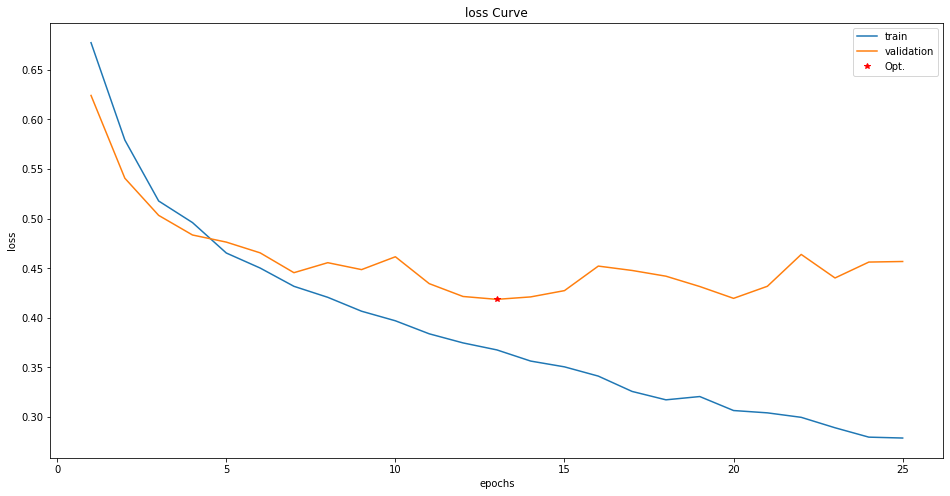

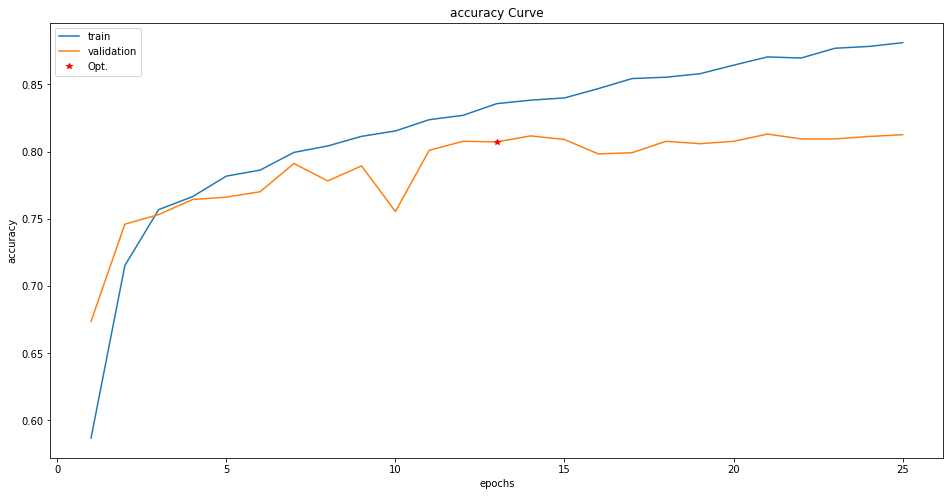

In [26]:
n = get_optimal_epoch(history)
#train loss vs validation loss
show_train_history(history,'loss','val_loss', n)
show_train_history(history,'accuracy','val_accuracy', n)

In [28]:
df_test = model_analyse(bi_model, x_test, X_test, y_test)
df_test[df_test.REAL != df_test.PRED]

88/88 [==============================] - 7s 82ms/step
Number of misclassified reviews: 507 out of 2800
Blind Test Accuracy:  0.8189


,REAL,PRED,TEXT
2,1,0.0,هه عيد ميلاد باللحم البرقوق والله شوف تيفي معن...
6,1,0.0,جبهه النصره تعرف القاعده مربط الجمل
12,1,0.0,الزعماء العرب قل كلهم استثنيت فربما لانك تخاف ...
20,0,1.0,نجح الطواغيت خداع شباب المسلمين فجعلوا جهادهم ...
21,1,0.0,بسم الله الرحمن الرحيم الشيخ غازي طير انت
...,...,...,...
2790,0,1.0,اغبا اعلام مغربي اتفوو جزاءري وافتخر
2791,1,0.0,وبعديين 😔 اثق بشخص انو قلبو عالقضيه وشريف بنفض...
2793,1,0.0,كيانك نتيجه استفتاء لتبارك للاسبانيا فتحها الع...
2794,0,1.0,انا شايف انو رغم عدوانيه هالقرار مازلنا مصرين ...


In [29]:
save_model(bi_model, 'aravec', 'bilstm', round(accuracy_val, 4))

Model Saved Successfully in ./models/aravec/ as bilstm_acc_0.8189
